In [1]:
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

# 加载模型，确保添加了自定义对象的引用
model = load_model('/root/Breast Cancer/Model Code/ModelFileH5/Version7-DIR.h5')


2024-03-10 00:54:37.985610: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 00:54:41.142677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 00:54:41.850974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:b1:00.0, compute capability: 8.9


In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 1. 加载图片
img_path = '/root/Breast Cancer/Datasets/40XResized/test/benign/SOB_B_TA-14-19854C-40-002.png'
img = image.load_img(img_path, target_size = (224, 224))

img_array = image.img_to_array(img)

img_array /= 255.0

img_array = np.expand_dims(img_array, axis = 0)

predictions = model.predict(img_array)

print(predictions)


2024-03-10 00:54:45.944827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-03-10 00:54:46.935975: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-10 00:54:46.935998: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-10 00:54:46.936084: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 4s 4s/step
[[0.9142424  0.08575761]]


2024-03-10 00:54:47.866824: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# 目录路径
folder_path = '/root/Breast Cancer/Datasets/40XResized/train/benign'

# 遍历目录下的所有文件
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    
    # 检查是否是文件，跳过目录
    if os.path.isfile(img_path):
        # 加载和预处理图片
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array /= 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # 预测
        predictions = model.predict(img_array)
        print(f"{img_name}: {predictions}")



1/1 [==============================] - 0s 39ms/step
SOB_B_A-14-22549CD-40-009.png: [[0.9622594 0.0377406]]
1/1 [==============================] - 0s 42ms/step
SOB_B_A-14-22549AB-40-001.png: [[0.9723932  0.02760675]]
1/1 [==============================] - 0s 48ms/step
SOB_B_A-14-22549CD-40-008.png: [[0.9691199  0.03088007]]
1/1 [==============================] - 0s 39ms/step
SOB_B_A-14-22549AB-40-002.png: [[0.95371294 0.04628712]]
1/1 [==============================] - 0s 48ms/step
SOB_B_A-14-22549CD-40-010.png: [[0.9600576  0.03994235]]
1/1 [==============================] - 0s 36ms/step
SOB_B_A-14-22549AB-40-003.png: [[0.9277057  0.07229427]]
1/1 [==============================] - 0s 36ms/step
SOB_B_A-14-22549CD-40-011.png: [[0.98012173 0.01987825]]
1/1 [==============================] - 0s 49ms/step
SOB_B_A-14-22549AB-40-004.png: [[0.953743   0.04625702]]
1/1 [==============================] - 0s 36ms/step
SOB_B_A-14-22549CD-40-012.png: [[0.9796275  0.02037249]]
1/1 [================

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (224, 224, 3)

test_dir = '/root/Breast Cancer/Datasets/40XResized/test'
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

Found 301 images belonging to 2 classes.


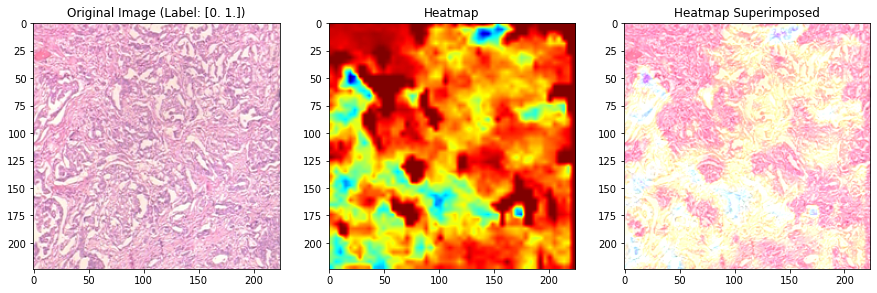

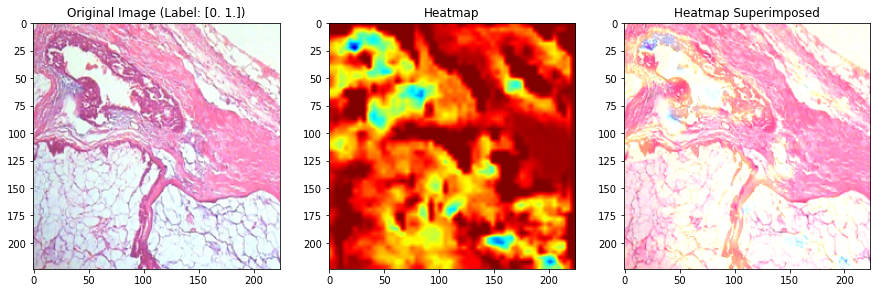

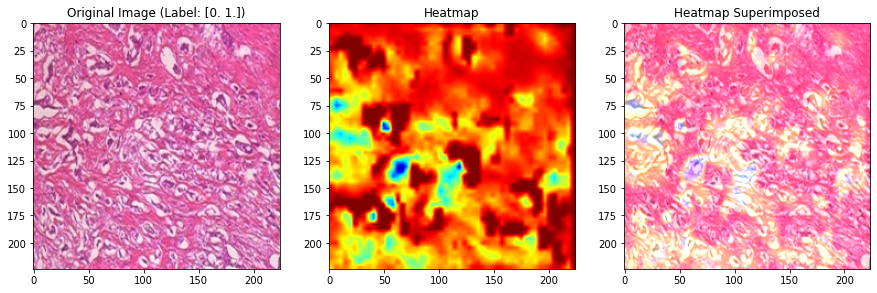

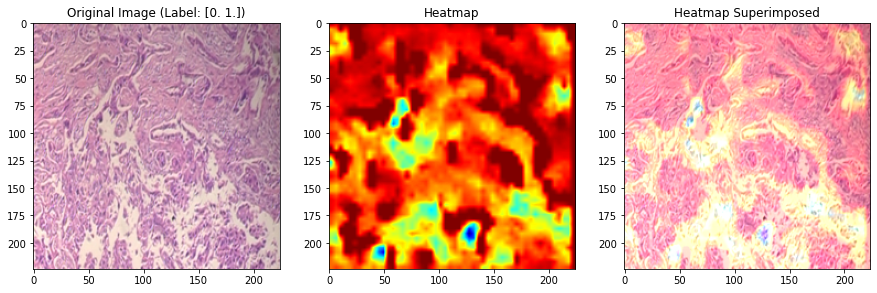

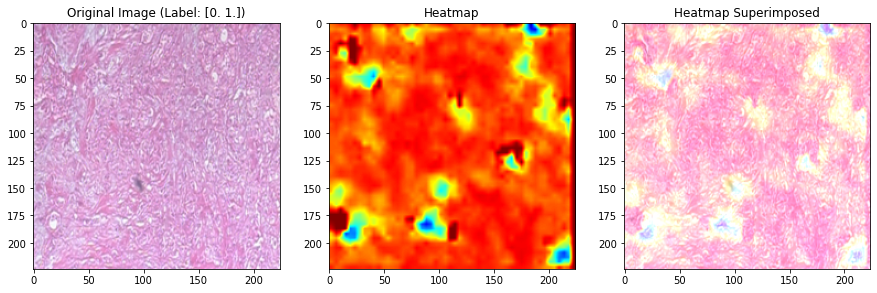

In [5]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_grad_cam(model, img_array, target_layer):
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(target_layer).output,
                                model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

num_images = 5

for i in range(num_images):
    batch = next(test_generator)
    img_array = batch[0]
    label = batch[1]

    heatmap = generate_grad_cam(model, img_array, 'conv2d_159')
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[1], img_array.shape[2]))[..., 0]
    
    # 修正: 将热力图叠加到原始图像前，确保原始图像未归一化
    img = img_array[0] * 255  # 假设原始图像已经归一化，这里转换回0-255范围

    # 转换热力图为彩色
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_resized * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img.astype('uint8'))
    plt.title(f'Original Image (Label: {label[0]})')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title('Heatmap')

    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Heatmap Superimposed')
    
    plt.show()


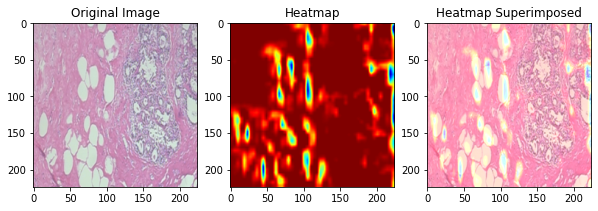

In [7]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# 加载和预处理单张图片
img_path = '/root/Breast Cancer/Datasets/40XResized/test/benign/SOB_B_A-14-22549G-40-001.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# 已定义的generate_grad_cam函数保持不变

# 使用模型和单张图片生成热力图
heatmap = generate_grad_cam(model, img_array, 'conv2d_159')
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224))[..., 0]

# 将热力图叠加到原始图像上
img_display = np.squeeze(img_array) * 255  # 确保img_array未归一化
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = heatmap_resized * 0.4 + img_display
superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

# 显示原始图像、热力图和叠加后的图像
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(img_display.astype('uint8'))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized)
plt.title('Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Heatmap Superimposed')

plt.show()
